In [1]:
import matplotlib.pyplot as plt
from pandas.core.common import flatten
import copy
import numpy as np
import random
import torch
import torchvision
from torch import nn
from torch import optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import StratifiedShuffleSplit
import wandb
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset
from sklearn.model_selection import StratifiedShuffleSplit
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns



In [2]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from sklearn.model_selection import StratifiedShuffleSplit
import numpy as np

def prepare(batch_size=64, use_data_augmentation=False):
   
    common_transforms = [
        transforms.Resize((256, 256)),
        transforms.ToTensor(),
        transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
    ]

    if use_data_augmentation:
        train_transform = transforms.Compose([
            transforms.RandomHorizontalFlip(), 
            transforms.RandomRotation(10), 
            *common_transforms,
        ])
    else:
        train_transform = transforms.Compose(common_transforms)

  
    test_transform = transforms.Compose(common_transforms)

    train_data_path = '/home/bincy/A2/CS-6910-A2/inaturalist_12K/train'
    test_data_path = '/home/bincy/A2/CS-6910-A2/inaturalist_12K/val'

   
    full_train_dataset = datasets.ImageFolder(train_data_path, transform=train_transform)

    # splitting 80:20 randomly
    validation_size = 0.2
    stratified_splitter = StratifiedShuffleSplit(n_splits=1, test_size=validation_size, random_state=42)
    train_indices, validation_indices = next(stratified_splitter.split(np.array(full_train_dataset.targets), np.array(full_train_dataset.targets)))

    # Create subsets for training and validation
    train_subset = Subset(full_train_dataset, train_indices)
    validation_dataset = datasets.ImageFolder(train_data_path, transform=test_transform)  
    validation_subset = Subset(validation_dataset, validation_indices)

   
    test_dataset = datasets.ImageFolder(test_data_path, transform=test_transform)

   
    trainloader = DataLoader(train_subset, batch_size=batch_size, shuffle=True)
    validationloader = DataLoader(validation_subset, batch_size=batch_size, shuffle=False)
    testloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    return trainloader, validationloader, testloader



In [3]:


class CNN(nn.Module):
    def __init__(self, num_classes=10, in_channels=3, num_filters=[32, 32, 32, 32, 32],kernel_size=3, pool_size=2,drop_conv=0.2, drop_dense=0.3,dense_neurons=100,activation="ReLU",activation_dense="ReLU",use_batch_norm=True, use_data_augmentation=True):
        super(CNN, self).__init__()
        self.conv_layers = nn.ModuleList()
        activations = {
        "ReLU": nn.ReLU(),
        "Tanh": nn.Tanh(),
        "GELU": nn.GELU(),
        "SiLU": nn.SiLU(), 
        "Mish": nn.Mish()}
        for out_channels in num_filters:
            kernel_size=kernel_size
            padding=kernel_size//2
            activation_function=activations.get(activation, nn.ReLU())

            self.conv_layers.append(
                nn.Sequential(
                    nn.Conv2d(in_channels, out_channels, kernel_size, padding=padding),
                    #nn.ReLU(),
                    activation_function,
                    nn.MaxPool2d(pool_size),
                    nn.Dropout(drop_conv)  
                )
            )
            
            if use_batch_norm:
                self.conv_layers.append(nn.BatchNorm2d(out_channels))  
            in_channels = out_channels
          
            
        self.dense_layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(num_filters[-1] * (256 // (pool_size**len(num_filters))) * (256 // (pool_size**len(num_filters))), dense_neurons),
            nn.ReLU(),
            nn.Dropout(drop_dense),  
            nn.Linear(dense_neurons, num_classes)
        )
        
    def forward(self, x):
        
        for layer in self.conv_layers:
            x = layer(x)
        
        x = self.dense_layers(x)
        return x


# Instantiate the model
model = CNN()
print(model)


CNN(
  (conv_layers): ModuleList(
    (0): Sequential(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU()
      (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (3): Dropout(p=0.2, inplace=False)
    )
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): Sequential(
      (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU()
      (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (3): Dropout(p=0.2, inplace=False)
    )
    (3): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): Sequential(
      (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU()
      (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (3): Dropout(p=0.2, inplace=False)
    )
    (5): BatchNorm2d(32, eps=1e-05, moment

In [4]:
def evaluation(dataloader,model):
    total, correct = 0, 0
    device = torch.device("cuda:0")
    for data in dataloader:
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        loss_fn = nn.CrossEntropyLoss()

        loss = loss_fn(outputs, labels)
                
        _, pred = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (pred == labels).sum().item()
        
    return 100 * correct / total,loss.item()

In [5]:
def get_all_preds(model, loader):
        all_preds = []
        all_labels = []
        device = torch.device("cuda:0")
        with torch.no_grad():
            for data in loader:
                inputs, labels = data
                inputs = inputs.to(device)
                outputs = model(inputs)
                _, predicted = torch.max(outputs, 1)
                all_preds.extend(predicted.cpu().numpy())
                all_labels.extend(labels.numpy())
        return all_labels, all_preds
def plot_confusion_matrix(labels, preds, classes):
        cm = confusion_matrix(labels, preds)
        fig, ax = plt.subplots(figsize=(10, 10))
        sns.heatmap(cm, annot=True, fmt='d', ax=ax, cmap='Blues', cbar=False)
        ax.set_xlabel('Predicted Labels')
        ax.set_ylabel('True Labels')
        ax.set_title('Confusion Matrix')
        ax.xaxis.set_ticklabels(classes)
        ax.yaxis.set_ticklabels(classes)
        plt.xticks(rotation=90)
        plt.yticks(rotation=0)
        wandb.log({"confusion_matrix": wandb.Image(fig)})
def imshow(img):
    npimg = img.cpu().numpy()  # Move tensor to CPU before converting to numpy
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()
def show_random_predictions(test_loader, model, class_names):
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model.eval()

    # Select 30 random images from the test loader
    random_indices = random.sample(range(len(test_loader.dataset)), 30)
    images, labels = [], []
    for idx in random_indices:
        image, label = test_loader.dataset[idx]
        images.append(image)
        labels.append(label)

    # Prepare the images for visualization
    images = torch.stack(images).to(device)
    outputs = model(images)
    _, preds = torch.max(outputs, 1)

    # Create a grid of images and their corresponding predictions
    fig, axs = plt.subplots(10, 3, figsize=(15, 30))
    fig.subplots_adjust(hspace=0.5)
    
    for i in range(10):
        for j in range(3):
            idx = i * 3 + j
            image = images[idx].cpu().permute(1, 2, 0)
            pred_class = class_names[preds[idx].item()]
            actual_class = class_names[labels[idx]]
            
            axs[i, j].imshow(image)
            axs[i, j].axis('off')
            axs[i, j].set_title(f'Predicted: {pred_class}, Actual: {actual_class}')

    plt.show()
    wandb.log({"image_grid": wandb.Image(fig)})
    
    # Close the figure to release memory
    plt.close(fig)

In [6]:
def fit(config):
#def fit():
    
    wandb.login() 
    #wandb.init(project="CS6910 A2",name="part a")
    
    loss_epoch_arr = []
    train_accuracy_arr=[]
    validation_accuracy_arr=[]
    loss_epoch_val=[]
    # early stop 
    patience = 5  # Number of epochs to wait for improvement before stopping
    best_val_loss = float('inf')  # Initialize best validation loss
    best_val_acc = 0  # Optionally, you could also track best validation accuracy
    no_improvement_count = 0  # 
    activation = config['activation']
    activation_dense = config['activation_dense']
    n=config['filter']
   
    batch_size = config['batch_size']
    epochs = config['epochs']
    drop_conv=config['drop_conv']
    drop_dense=config['drop_dense']
    kernel_size=config['kernel_size']
    filter_mult=config['filter_mult']
    dense_neurons=config['dense']
    use_batch_norm=config['batch_normalization']
    use_data_augmentation=config['data_augmentation']
    trainloader,validationloader,testloader=prepare(batch_size,use_data_augmentation)
   
    device = torch.device("cuda:0")
    if filter_mult == 1:
        num_filters = [n, n, n, n, n]
    if filter_mult==2:
        num_filters = [n* (2 ** i) for i in range(5)]
    if filter_mult==0.5:
        num_filters = [n//(2 ** i) for i in range(5)]
    device = torch.device("cuda:0")
    net = CNN(activation_dense=activation_dense,num_filters=num_filters,drop_conv=drop_conv,drop_dense=drop_dense,use_batch_norm=use_batch_norm,use_data_augmentation=use_data_augmentation,dense_neurons=dense_neurons,kernel_size=kernel_size,activation=activation).to(device)
       
    print(net)
    num_params = sum(p.numel() for p in net.parameters() if p.requires_grad)
    print("Number of parameters in the model:", num_params)
    loss_fn = nn.CrossEntropyLoss()
    opt = optim.Adam(net.parameters())  
    n_iters = np.ceil(10000/batch_size)
  
    min_loss = 1000
    for epoch in range(epochs):

        for i, data in enumerate(trainloader, 0):

            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)
            opt.zero_grad()
            outputs = net(inputs)
            train_loss = loss_fn(outputs, labels)
            train_loss.backward()
            opt.step()
            del inputs, labels, outputs
            torch.cuda.empty_cache()
            if min_loss > train_loss.item():
                min_loss = train_loss.item()
                best_model = copy.deepcopy(net.state_dict())
                print('Min loss %0.2f' % min_loss)
                
            if i % 1000 == 0:
                print('Iteration: %d/%d, Loss: %0.2f' % (i, n_iters, train_loss.item()))
            
        loss_epoch_arr.append(train_loss.item())
        train_accuracy,t_loss=evaluation(trainloader,net)
        net.eval()
        validation_accuracy,validation_loss=evaluation(validationloader,net)
        train_accuracy_arr.append(train_accuracy)
        validation_accuracy_arr.append(validation_accuracy)
        loss_epoch_val.append(validation_loss)
            
        print('Epoch: %d/%d, validayion acc: %0.2f,Train acc: %0.2f ,val loss: %0.2f, train loss: %0.2f'%(
            epoch, epochs, 
            validation_accuracy,train_accuracy,validation_loss,train_loss.item()))
        
        wandb.log({"accuracy_train": train_accuracy, "accuracy_validation": validation_accuracy, "loss_train": train_loss.item(), "loss_validation": validation_loss, 'epochs': epoch})
        if validation_loss < best_val_loss:
            best_val_loss = validation_loss
            best_val_acc = validation_accuracy  # Update best validation accuracy if tracking
            best_model = copy.deepcopy(net.state_dict())  # Save the best model state
            no_improvement_count = 0  # Reset counter
            print('Improvement found at epoch {}: validation loss: {}, validation accuracy: {}'.format(epoch, validation_loss, validation_accuracy))
        else:
            no_improvement_count += 1
            print('No improvement in epoch {}. Current validation loss: {}, Best validation loss: {}'.format(epoch, validation_loss, best_val_loss))

        # Early stopping check
        if no_improvement_count >= patience:
            print('No improvement in validation loss for {} consecutive epochs. Stopping training...'.format(patience))
            break  # Exit the training loop
    
        net.train()
        
        
    plt.plot(loss_epoch_arr)
    plt.show()
    plt.plot(range(1, epochs + 1), train_accuracy_arr, label='Training Accuracy')
    plt.plot(range(1, epochs + 1), validation_accuracy_arr, label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy per Epoch')
    plt.legend()
    plt.grid(True)
    #best_model_accuracy,best_model_loss=evaluation(validationloader,net)
    print("saving the model--wait")
    path_to_save='/home/bincy/A2/CS-6910-A2/model.pth'
    torch.save(net.state_dict(), path_to_save)
    #print('validation acc from best model: %0.2f,val loss: %0.2f'%(best_model_accuracy,best_model_loss))
    print("evaluating on test data")
    
    best_model_test_accuracy,best_model_test_loss=evaluation(testloader,net)
    true_labels, predictions = get_all_preds(net, testloader)  
    classes = testloader.dataset.classes 

    plot_confusion_matrix(true_labels, predictions, classes)
    print('test acc from best model: %0.2f,test loss: %0.2f'%(best_model_test_accuracy,best_model_test_loss))
    class_names = ('Amphibia', 'Animalia', 'Arachnida', 'Aves', 'Fungi', 'Insecta', 'Mammalia', 'Mollusca', 'Plantae', 'Reptilia')
    show_random_predictions(testloader, net, class_names)
    


In [7]:
def train():
   with wandb.init() as run:
        run_name = f'epoch_{wandb.config.epochs}_acti_{wandb.config.activation}_acti_dense_{wandb.config.activation_dense}__batchsize_{wandb.config.batch_size}__kernel_size_{wandb.config.kernel_size}_denseneurons_{wandb.config.dense}_filter_mult_{wandb.config.filter_mult}__drop_conv_{wandb.config.drop_conv}__drop_dense_{wandb.config.drop_dense}_filter_{wandb.config.filter}_aug_{wandb.config.data_augmentation}_batch_norm_{wandb.config.batch_normalization}'
        wandb.run.name = run_name
        print(run_name)
        fit(wandb.config)
        wandb.run.save()


Create sweep with ID: 1xgjp5zm
Sweep URL: https://wandb.ai/bincyantonym/CS6910%20A2/sweeps/1xgjp5zm


wandb: Agent Starting Run: 8vyanqnd with config:
wandb: 	activation: ReLU
wandb: 	activation_dense: ReLU
wandb: 	batch_normalization: Yes
wandb: 	batch_size: 16
wandb: 	data_augmentation: Yes
wandb: 	dense: 1000
wandb: 	drop_conv: 0.1
wandb: 	drop_dense: 0.3
wandb: 	epochs: 10
wandb: 	filter: 32
wandb: 	filter_mult: 2
wandb: 	kernel_size: 3
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


epoch_10_acti_ReLU_acti_dense_ReLU__batchsize_16__kernel_size_3_denseneurons_1000_filter_mult_2__drop_conv_0.1__drop_dense_0.3_filter_32_aug_Yes_batch_norm_Yes
CNN(
  (conv_layers): ModuleList(
    (0): Sequential(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU()
      (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (3): Dropout(p=0.1, inplace=False)
    )
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): Sequential(
      (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU()
      (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (3): Dropout(p=0.1, inplace=False)
    )
    (3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): Sequential(
      (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU()
      (2): Max

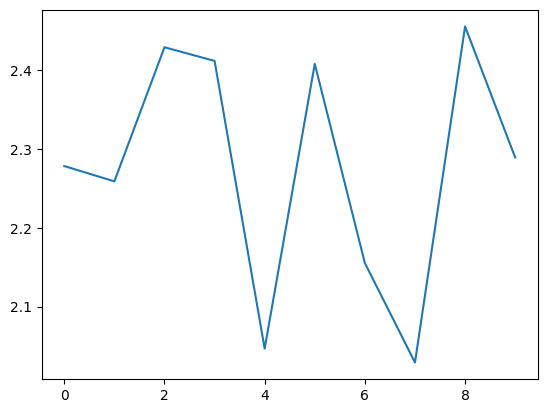

saving the model--wait
evaluating on test data
test acc from best model: 14.20,test loss: 2.58


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

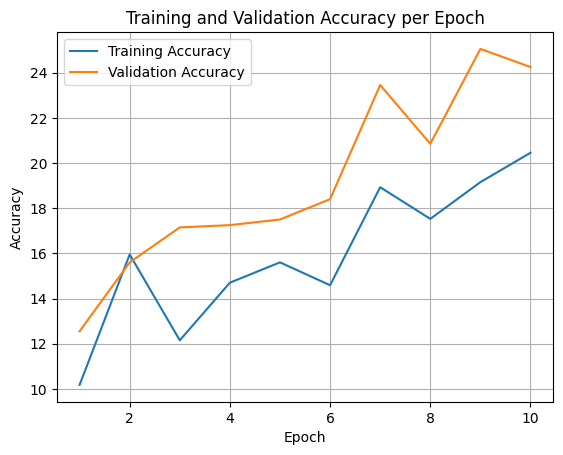

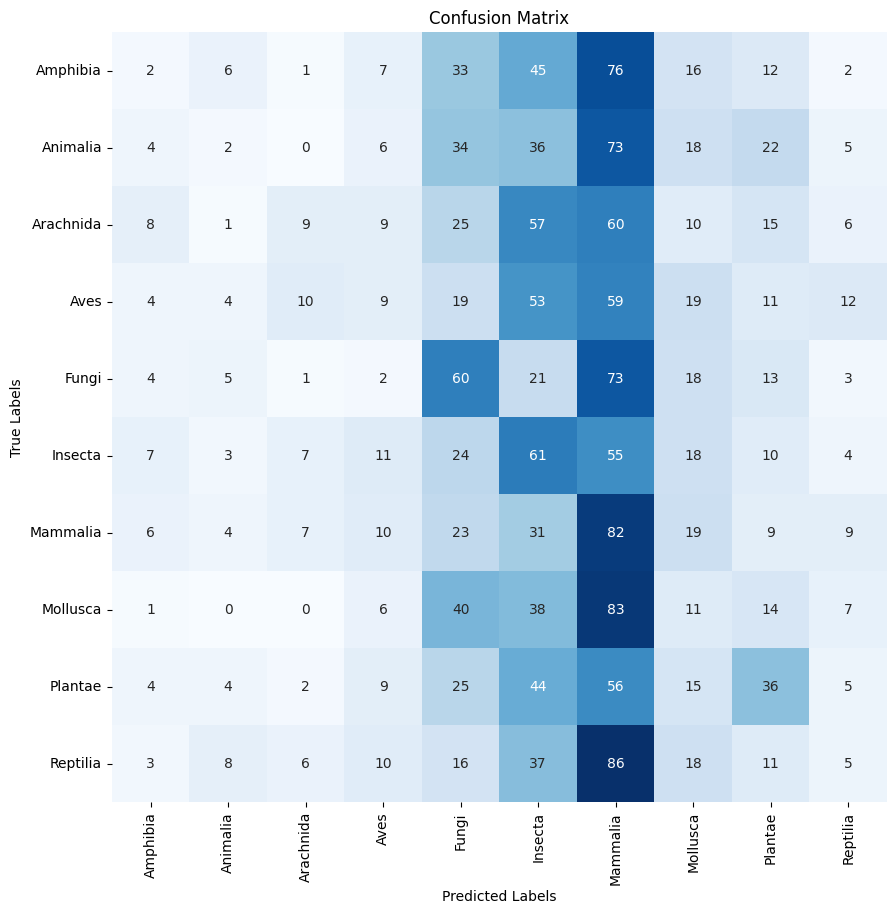

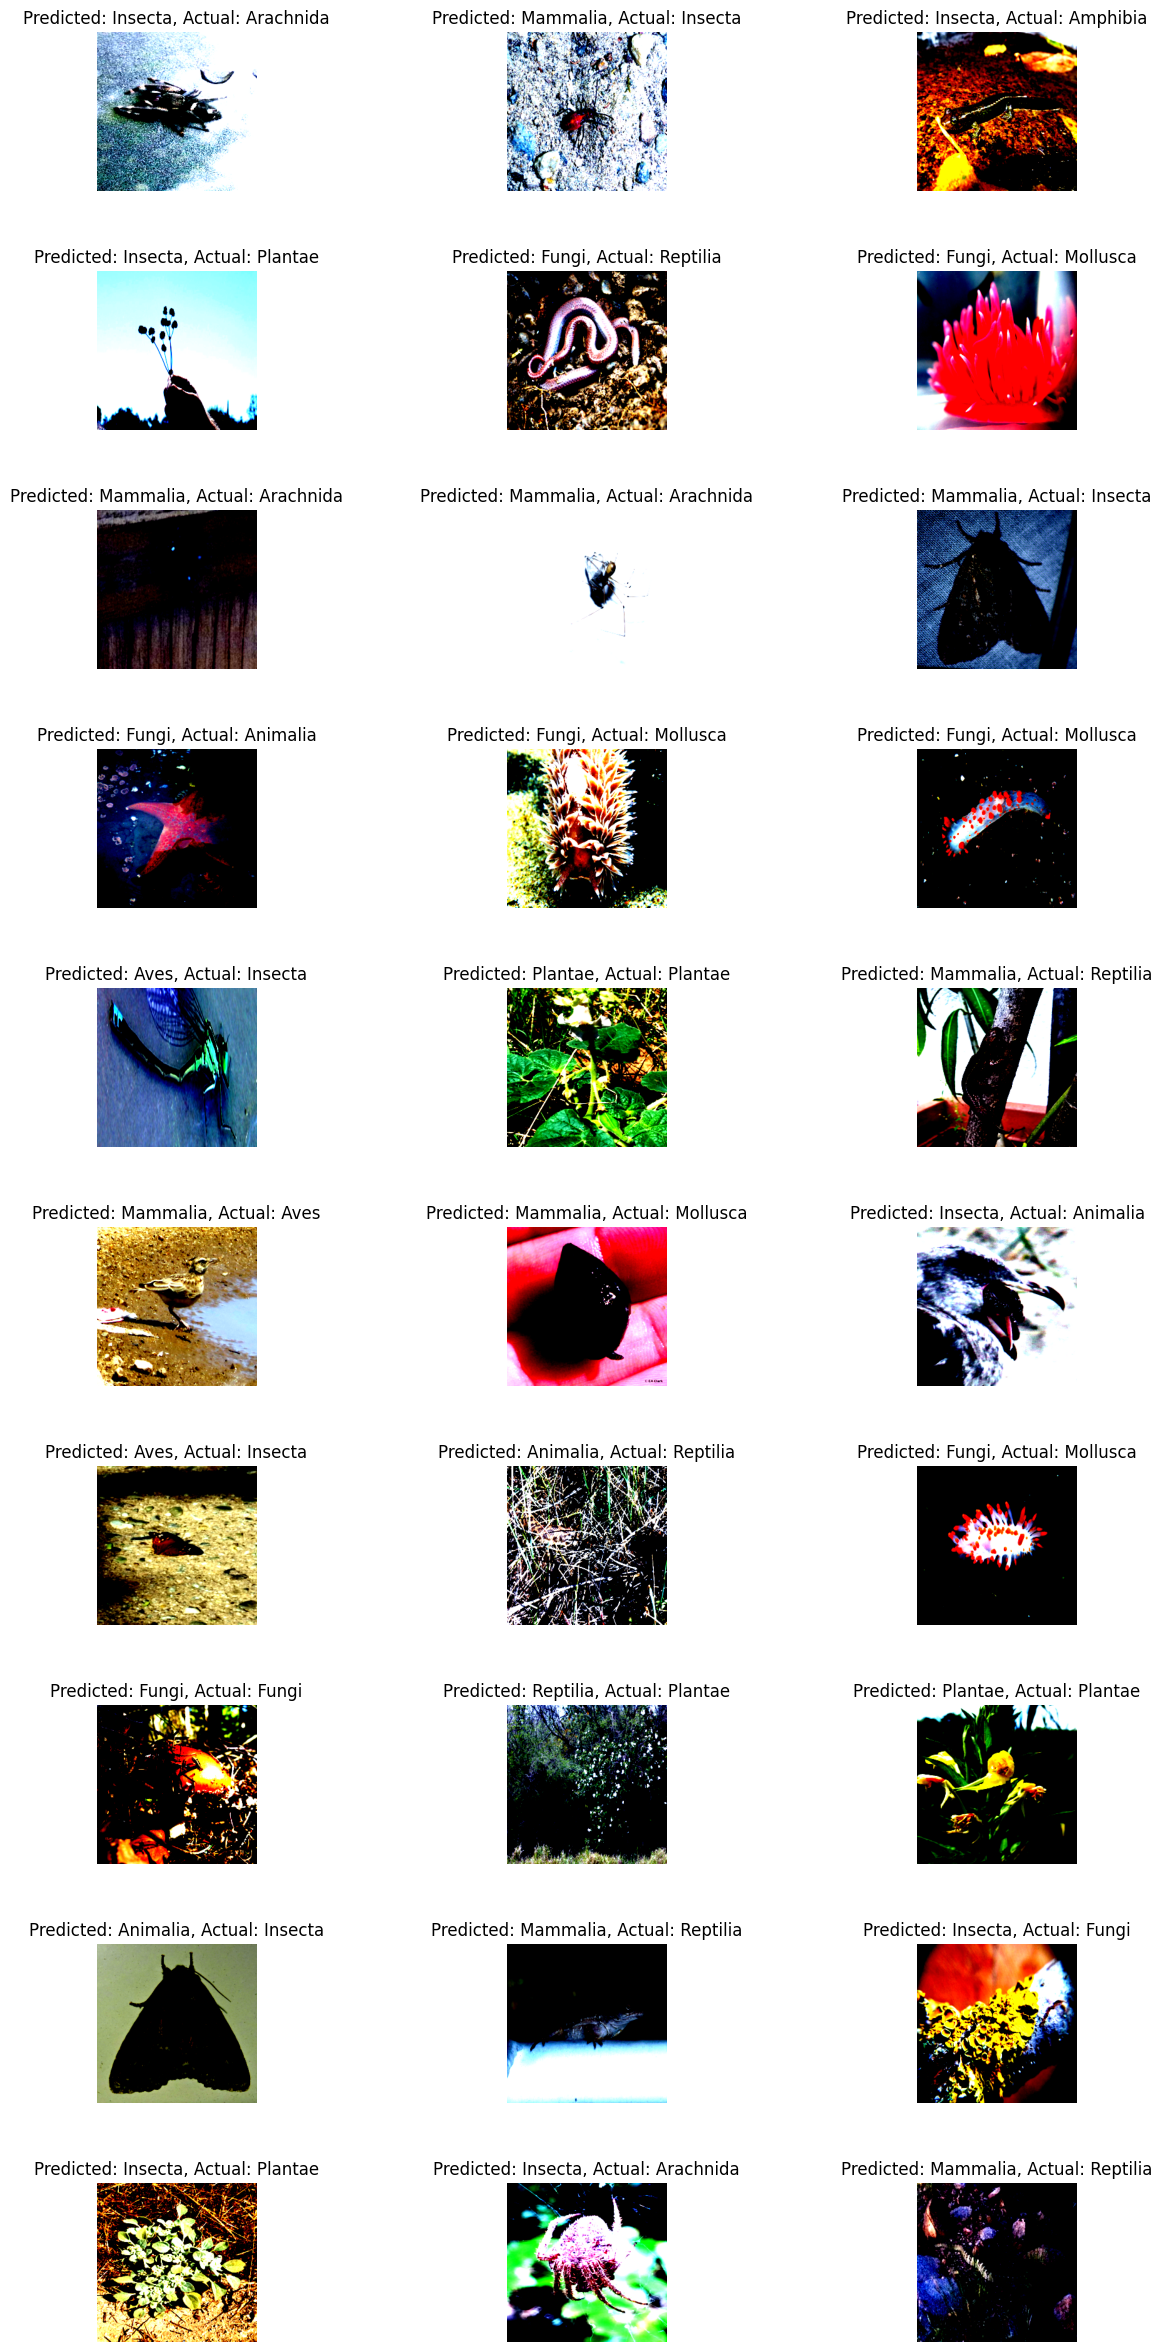

wandb: Agent Starting Run: w0c24tg3 with config:
wandb: 	activation: ReLU
wandb: 	activation_dense: ReLU
wandb: 	batch_normalization: Yes
wandb: 	batch_size: 16
wandb: 	data_augmentation: Yes
wandb: 	dense: 1000
wandb: 	drop_conv: 0.1
wandb: 	drop_dense: 0.2
wandb: 	epochs: 10
wandb: 	filter: 32
wandb: 	filter_mult: 2
wandb: 	kernel_size: 3
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


epoch_10_acti_ReLU_acti_dense_ReLU__batchsize_16__kernel_size_3_denseneurons_1000_filter_mult_2__drop_conv_0.1__drop_dense_0.2_filter_32_aug_Yes_batch_norm_Yes
CNN(
  (conv_layers): ModuleList(
    (0): Sequential(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU()
      (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (3): Dropout(p=0.1, inplace=False)
    )
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): Sequential(
      (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU()
      (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (3): Dropout(p=0.1, inplace=False)
    )
    (3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): Sequential(
      (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU()
      (2): Max

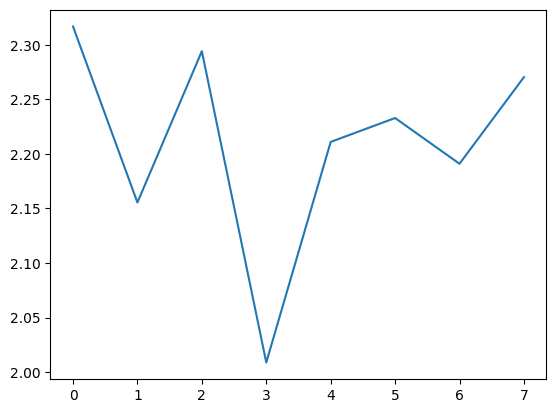

Traceback (most recent call last):
  File "/tmp/ipykernel_15977/1142878270.py", line 6, in train
    fit(wandb.config)
  File "/tmp/ipykernel_15977/2645128933.py", line 103, in fit
    plt.plot(range(1, epochs + 1), train_accuracy_arr, label='Training Accuracy')
  File "/home/bincy/anaconda3/envs/A1/lib/python3.8/site-packages/matplotlib/pyplot.py", line 2812, in plot
    return gca().plot(
  File "/home/bincy/anaconda3/envs/A1/lib/python3.8/site-packages/matplotlib/axes/_axes.py", line 1688, in plot
    lines = [*self._get_lines(*args, data=data, **kwargs)]
  File "/home/bincy/anaconda3/envs/A1/lib/python3.8/site-packages/matplotlib/axes/_base.py", line 311, in __call__
    yield from self._plot_args(
  File "/home/bincy/anaconda3/envs/A1/lib/python3.8/site-packages/matplotlib/axes/_base.py", line 504, in _plot_args
    raise ValueError(f"x and y must have same first dimension, but "
ValueError: x and y must have same first dimension, but have shapes (10,) and (8,)


Run w0c24tg3 errored:
Traceback (most recent call last):
  File "/home/bincy/anaconda3/envs/A1/lib/python3.8/site-packages/wandb/agents/pyagent.py", line 308, in _run_job
    self._function()
  File "/tmp/ipykernel_15977/1142878270.py", line 6, in train
    fit(wandb.config)
  File "/tmp/ipykernel_15977/2645128933.py", line 103, in fit
    plt.plot(range(1, epochs + 1), train_accuracy_arr, label='Training Accuracy')
  File "/home/bincy/anaconda3/envs/A1/lib/python3.8/site-packages/matplotlib/pyplot.py", line 2812, in plot
    return gca().plot(
  File "/home/bincy/anaconda3/envs/A1/lib/python3.8/site-packages/matplotlib/axes/_axes.py", line 1688, in plot
    lines = [*self._get_lines(*args, data=data, **kwargs)]
  File "/home/bincy/anaconda3/envs/A1/lib/python3.8/site-packages/matplotlib/axes/_base.py", line 311, in __call__
    yield from self._plot_args(
  File "/home/bincy/anaconda3/envs/A1/lib/python3.8/site-packages/matplotlib/axes/_base.py", line 504, in _plot_args
    raise Valu

wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


epoch_10_acti_ReLU_acti_dense_ReLU__batchsize_32__kernel_size_3_denseneurons_1000_filter_mult_1__drop_conv_0.2__drop_dense_0.3_filter_32_aug_Yes_batch_norm_Yes
CNN(
  (conv_layers): ModuleList(
    (0): Sequential(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU()
      (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (3): Dropout(p=0.2, inplace=False)
    )
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): Sequential(
      (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU()
      (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (3): Dropout(p=0.2, inplace=False)
    )
    (3): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): Sequential(
      (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU()
      (2): MaxP

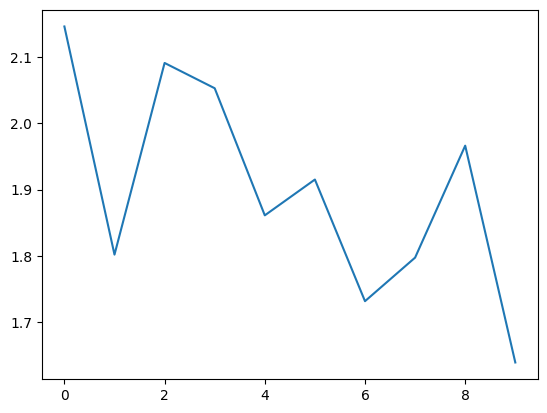

saving the model--wait
evaluating on test data
test acc from best model: 23.30,test loss: 1.90


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

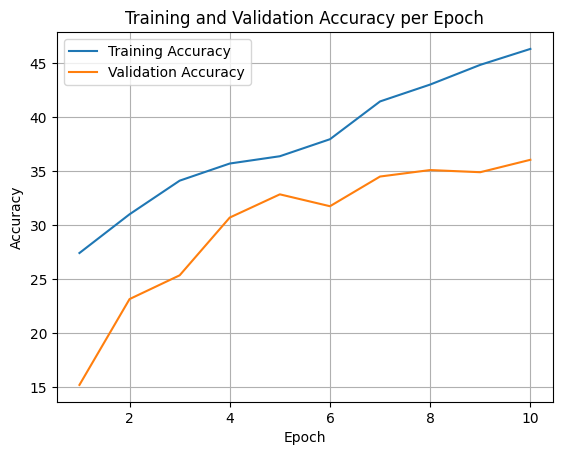

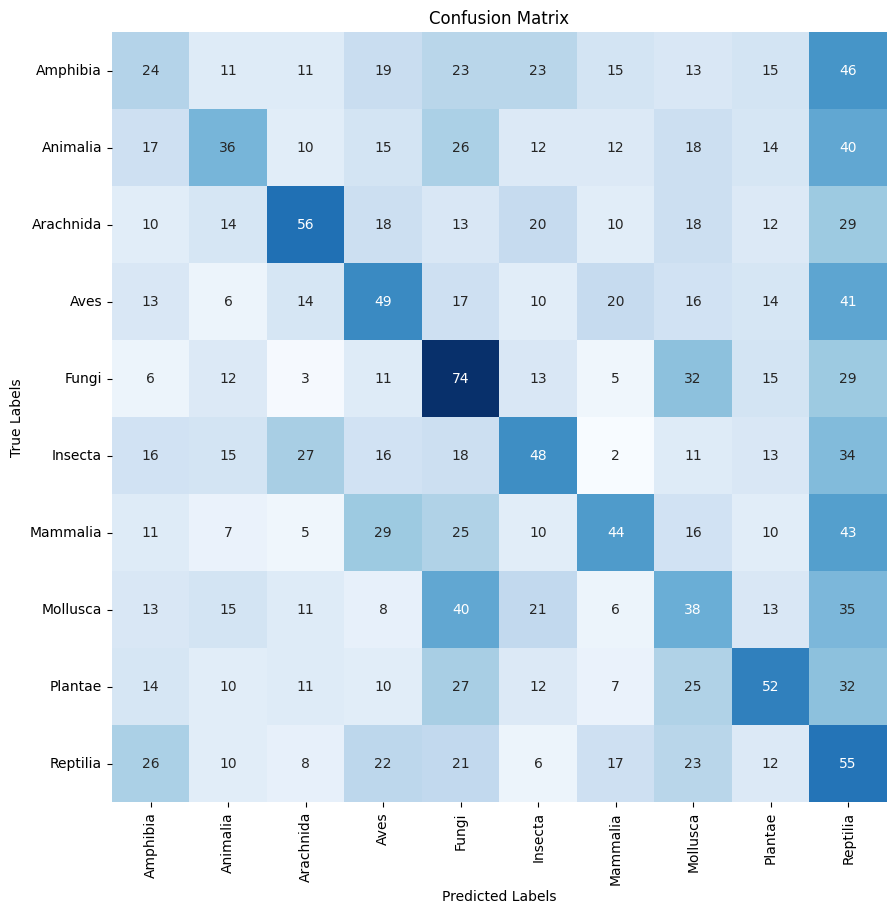

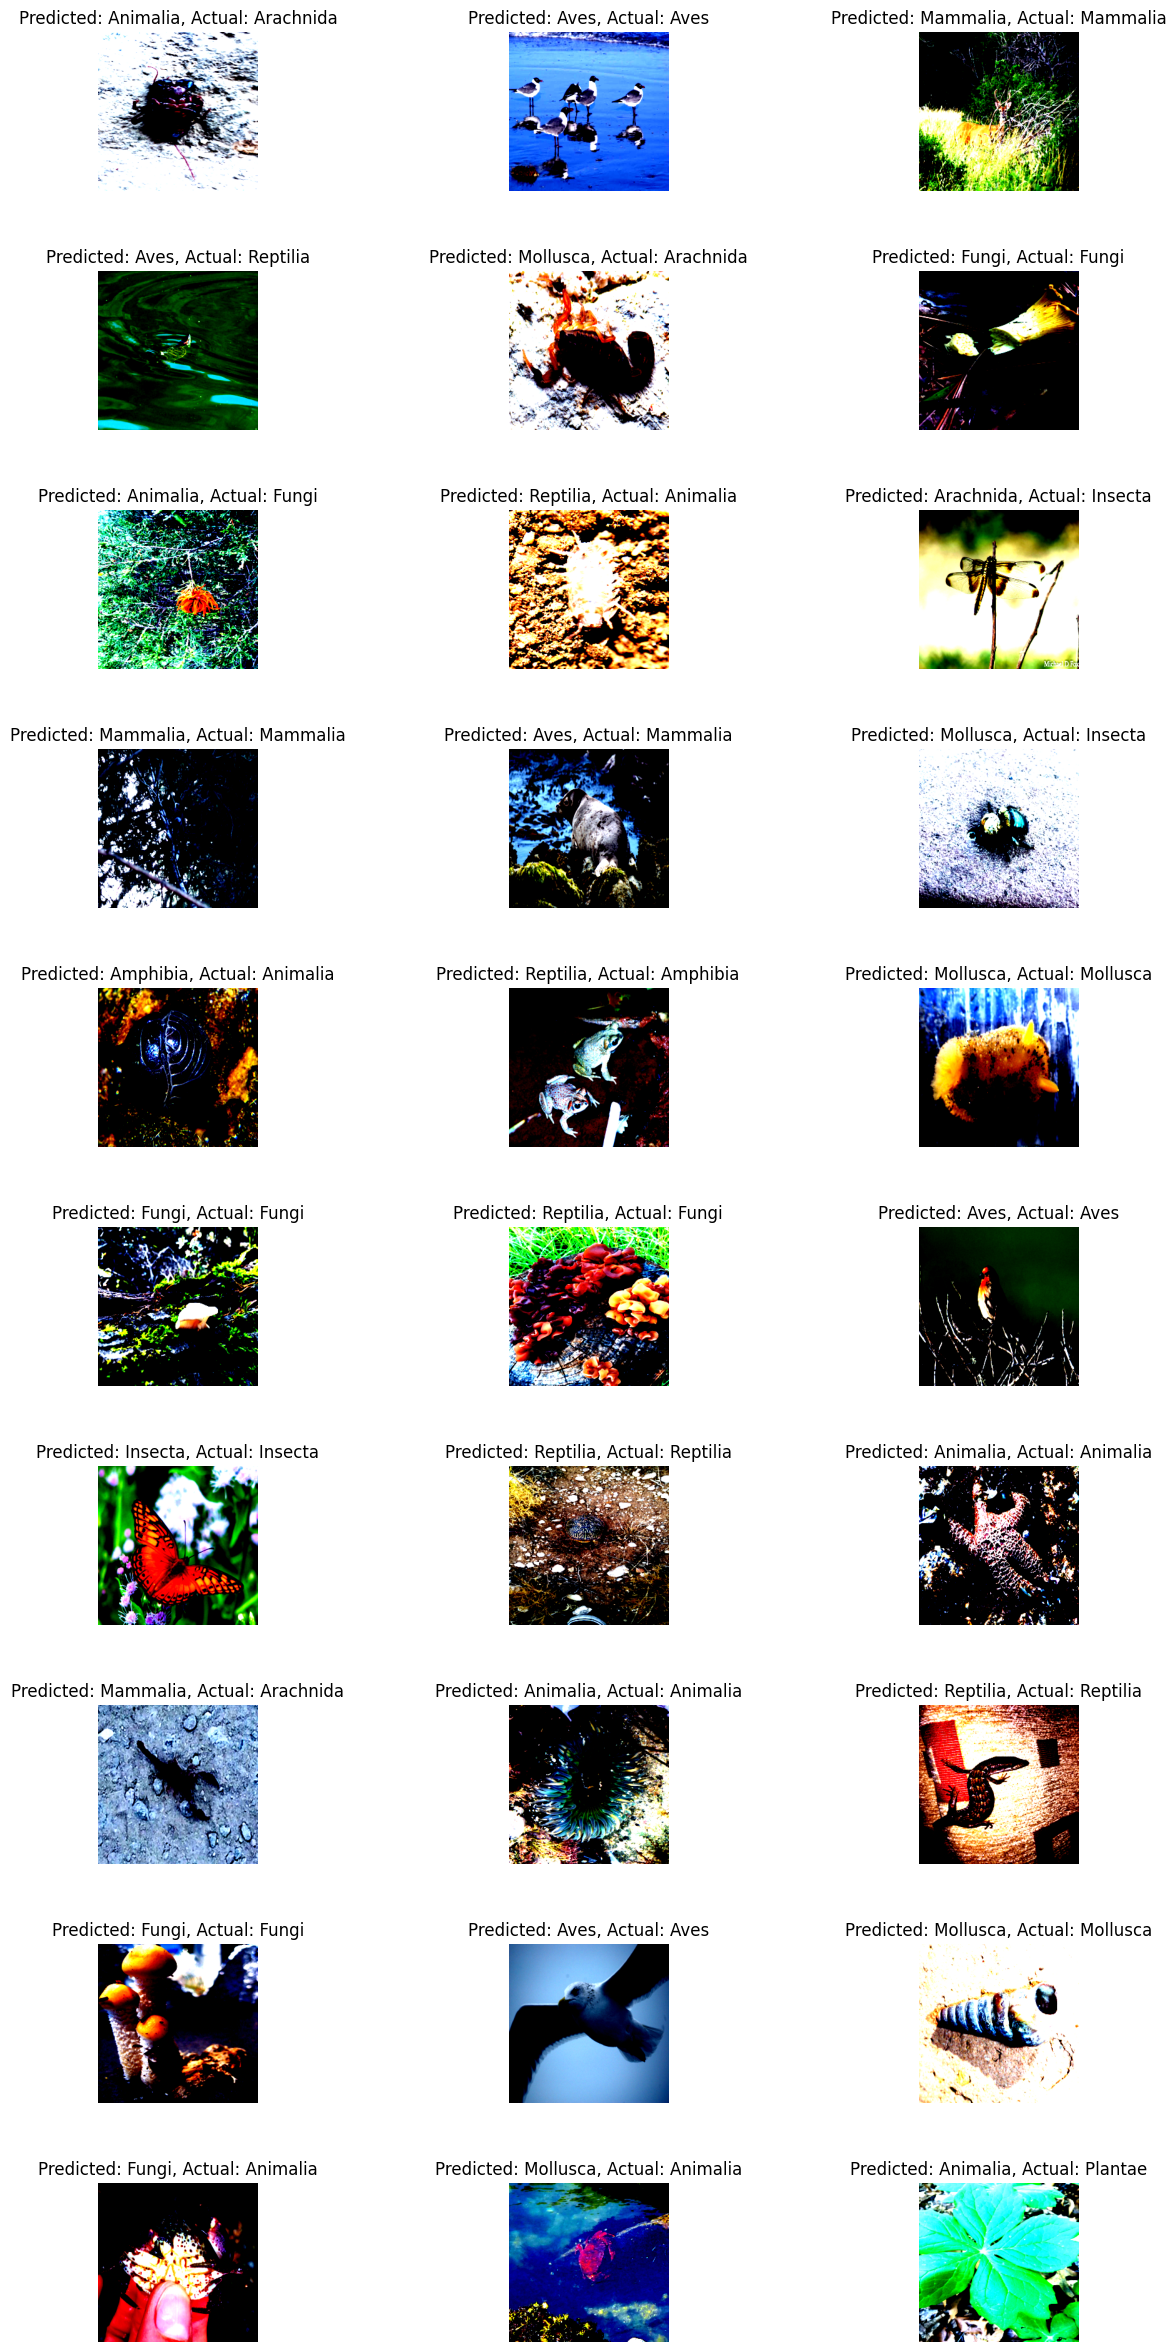

wandb: Agent Starting Run: 9rncuidh with config:
wandb: 	activation: ReLU
wandb: 	activation_dense: ReLU
wandb: 	batch_normalization: Yes
wandb: 	batch_size: 32
wandb: 	data_augmentation: Yes
wandb: 	dense: 1000
wandb: 	drop_conv: 0.2
wandb: 	drop_dense: 0.1
wandb: 	epochs: 10
wandb: 	filter: 32
wandb: 	filter_mult: 1
wandb: 	kernel_size: 3
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


epoch_10_acti_ReLU_acti_dense_ReLU__batchsize_32__kernel_size_3_denseneurons_1000_filter_mult_1__drop_conv_0.2__drop_dense_0.1_filter_32_aug_Yes_batch_norm_Yes
CNN(
  (conv_layers): ModuleList(
    (0): Sequential(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU()
      (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (3): Dropout(p=0.2, inplace=False)
    )
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): Sequential(
      (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU()
      (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (3): Dropout(p=0.2, inplace=False)
    )
    (3): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): Sequential(
      (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU()
      (2): MaxP

wandb: Ctrl + C detected. Stopping sweep.
Traceback (most recent call last):
  File "/tmp/ipykernel_15977/1142878270.py", line 6, in train
    fit(wandb.config)
  File "/tmp/ipykernel_15977/2645128933.py", line 59, in fit
    opt.step()
  File "/home/bincy/anaconda3/envs/A1/lib/python3.8/site-packages/torch/optim/optimizer.py", line 385, in wrapper
    out = func(*args, **kwargs)
  File "/home/bincy/anaconda3/envs/A1/lib/python3.8/site-packages/torch/optim/optimizer.py", line 76, in _use_grad
    ret = func(self, *args, **kwargs)
  File "/home/bincy/anaconda3/envs/A1/lib/python3.8/site-packages/torch/optim/adam.py", line 166, in step
    adam(
  File "/home/bincy/anaconda3/envs/A1/lib/python3.8/site-packages/torch/optim/adam.py", line 316, in adam
    func(params,
  File "/home/bincy/anaconda3/envs/A1/lib/python3.8/site-packages/torch/optim/adam.py", line 565, in _multi_tensor_adam
    bias_correction1 = [1 - beta1 ** _get_value(step) for step in device_state_steps]
  File "/home/bincy

In [9]:
sweep_config = {
  "name": "the second bayes sweep with early stop",
  "metric": {
      "name": "accuracy_validation",
      "goal": "maximize"
  },
  "method": "bayes",
  "parameters": {
        "epochs": {
            "values": [10]
        },
        "batch_size": {
            "values": [16,32]
        },
        "filter":{
            "values":[32]
        },
        "kernel_size":{
            "values":[3]
        },
        "drop_conv": {
            "values": [0.1,0.2]
        },
        "drop_dense": {
            "values": [0.1,0.2,0.3]
        },
        "filter_mult": {
            "values": [1,2]
        },
        "activation": {
            "values": ["ReLU"]  # Specify activation functions as strings
        },
        "activation_dense": {
            "values": ["ReLU"]  # Specify activation functions as strings
        },
        "dense": {
            "values": [1000]  # Specify activation functions as strings
        },
        "data_augmentation": {"values": ["Yes"]},
        "batch_normalization": {"values": ["Yes"]},
    }
}
sweep_id = wandb.sweep(sweep_config, project="CS6910 A2")
wandb.agent(sweep_id, function = train,count=30)
wandb.finish()